In [436]:
import re
import itertools
import numpy as np
import pandas as pd
import skfuzzy as fuzzy
import skfuzzy.control as ctrl
import matplotlib.pyplot as plt
from tabulate import tabulate

## Fuzzificação

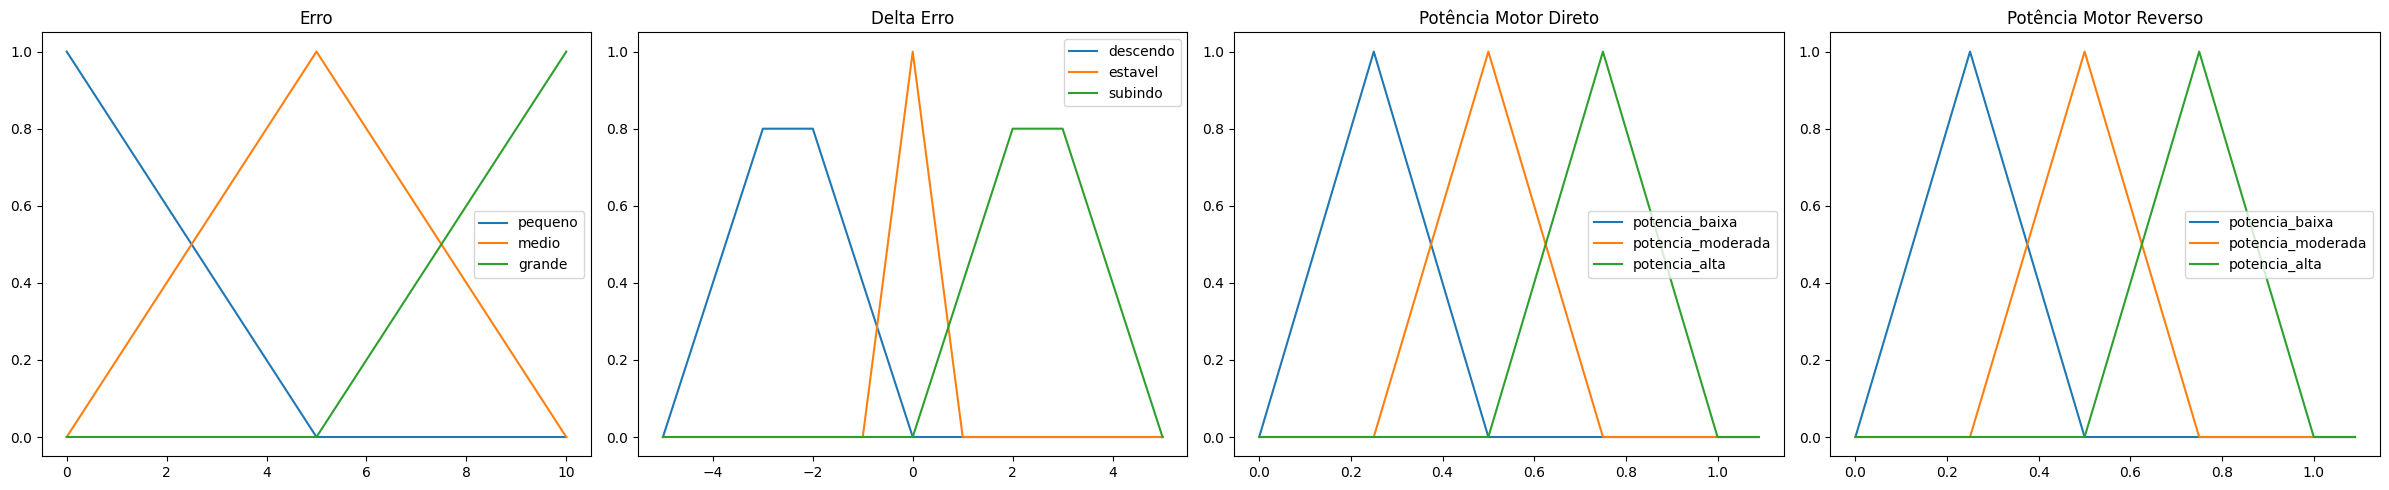

In [437]:
import numpy as np
import skfuzzy as fuzz
import skfuzzy.control as ctrl
import matplotlib.pyplot as plt

# Definindo os universos para as variáveis de entrada e saída
erro = ctrl.Antecedent(np.arange(0, 11, 1), 'erro')
delta_erro = ctrl.Antecedent(np.arange(-5, 6, 1), 'delta_erro')
potencia_motor_direto = ctrl.Consequent(np.arange(0, 1.1, 0.01), 'potencia_motor_direto')
potencia_motor_reverso = ctrl.Consequent(np.arange(0, 1.1, 0.01), 'potencia_motor_reverso')

# Definindo funções de pertinência para o erro
erro['pequeno'] = fuzz.trimf(erro.universe, [0, 0, 5])
erro['medio'] = fuzz.trimf(erro.universe, [0, 5, 10])
erro['grande'] = fuzz.trimf(erro.universe, [5, 10, 10])

# Definindo funções de pertinência para delta_erro
delta_erro['descendo'] = fuzz.trimf(delta_erro.universe, [-5, -2.5, 0])
delta_erro['estavel'] = fuzz.trimf(delta_erro.universe, [-1, 0, 1])
delta_erro['subindo'] = fuzz.trimf(delta_erro.universe, [0, 2.5, 5])

# Definindo funções de pertinência para potencia_motor_direto e potencia_motor_reverso
potencia_motor_direto['potencia_baixa'] = fuzz.trimf(potencia_motor_direto.universe, [0, 0.25, 0.5])
potencia_motor_direto['potencia_moderada'] = fuzz.trimf(potencia_motor_direto.universe, [0.25, 0.5, 0.75])
potencia_motor_direto['potencia_alta'] = fuzz.trimf(potencia_motor_direto.universe, [0.5, 0.75, 1])

potencia_motor_reverso['potencia_baixa'] = fuzz.trimf(potencia_motor_reverso.universe, [0, 0.25, 0.5])
potencia_motor_reverso['potencia_moderada'] = fuzz.trimf(potencia_motor_reverso.universe, [0.25, 0.5, 0.75])
potencia_motor_reverso['potencia_alta'] = fuzz.trimf(potencia_motor_reverso.universe, [0.5, 0.75, 1])

# Configurando o gráfico para mostrar todas as funções de pertinência em uma única imagem
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

# Plotando manualmente as funções de pertinência de cada variável
for term in erro.terms:
    axs[0].plot(erro.universe, erro[term].mf, label=term)
axs[0].set_title("Erro")
axs[0].legend()

for term in delta_erro.terms:
    axs[1].plot(delta_erro.universe, delta_erro[term].mf, label=term)
axs[1].set_title("Delta Erro")
axs[1].legend()

for term in potencia_motor_direto.terms:
    axs[2].plot(potencia_motor_direto.universe, potencia_motor_direto[term].mf, label=term)
axs[2].set_title("Potência Motor Direto")
axs[2].legend()

for term in potencia_motor_reverso.terms:
    axs[3].plot(potencia_motor_reverso.universe, potencia_motor_reverso[term].mf, label=term)
axs[3].set_title("Potência Motor Reverso")
axs[3].legend()

plt.tight_layout()
plt.show()


## Base de Regras

In [438]:
# Criação das regras para o controle direto
rule1_direto = ctrl.Rule(erro['grande'] & delta_erro['descendo'], potencia_motor_direto['potencia_alta'])
rule2_direto = ctrl.Rule(erro['medio'] & delta_erro['descendo'], potencia_motor_direto['potencia_moderada'])
rule3_direto = ctrl.Rule(erro['pequeno'] & delta_erro['descendo'], potencia_motor_direto['potencia_baixa'])
rule4_direto = ctrl.Rule(erro['medio'] & delta_erro['estavel'], potencia_motor_direto['potencia_moderada'])
rule5_direto = ctrl.Rule(erro['pequeno'] & delta_erro['estavel'], potencia_motor_direto['potencia_baixa'])
rule6_direto = ctrl.Rule(erro['medio'] & delta_erro['subindo'], potencia_motor_direto['potencia_baixa'])

# Criação das regras para o controle reverso
rule1_reverso = ctrl.Rule(erro['grande'] & delta_erro['descendo'], potencia_motor_reverso['potencia_alta'])
rule2_reverso = ctrl.Rule(erro['medio'] & delta_erro['descendo'], potencia_motor_reverso['potencia_moderada'])
rule3_reverso = ctrl.Rule(erro['pequeno'] & delta_erro['descendo'], potencia_motor_reverso['potencia_baixa'])
rule4_reverso = ctrl.Rule(erro['medio'] & delta_erro['estavel'], potencia_motor_reverso['potencia_moderada'])
rule5_reverso = ctrl.Rule(erro['pequeno'] & delta_erro['estavel'], potencia_motor_reverso['potencia_baixa'])
rule6_reverso = ctrl.Rule(erro['medio'] & delta_erro['subindo'], potencia_motor_reverso['potencia_baixa'])

## Simulação do Controle

In [543]:
# Configurando os sistemas de controle fuzzy para cada par de motores
controle_direto = ctrl.ControlSystem([rule1_direto, rule2_direto, rule3_direto, rule4_direto, rule5_direto, rule6_direto])
controle_reverso = ctrl.ControlSystem([rule1_reverso, rule2_reverso, rule3_reverso, rule4_reverso, rule5_reverso, rule6_reverso])

simulacao_direto = ctrl.ControlSystemSimulation(controle_direto)
simulacao_reverso = ctrl.ControlSystemSimulation(controle_reverso)

# Parâmetros de simulação
Umáx = 4  # Velocidade máxima de descida no S-mode (m/s)
d_altura = 100  # Altura inicial do drone (exemplo)
tempo = np.arange(0, 400, 1)

# Lista para armazenar as alturas ao longo do tempo
alturas = [d_altura]

# Simulação de controle ao longo do tempo
for i in tempo:
    # Ajuste dos valores de erro e delta_erro para simulação
    erro_atual = max(alturas[-1] - 5, 0)  # Erro como diferença entre altura e ponto alvo
    delta_erro_atual = np.random.uniform(-1, 1)  # Exemplo de variação aleatória no erro

    # Controle direto (primeiro par de motores)
    simulacao_direto.input['erro'] = erro_atual
    simulacao_direto.input['delta_erro'] = delta_erro_atual
    simulacao_direto.compute()
    potencia_ajuste_direto = simulacao_direto.output['potencia_motor_direto']

    # Controle reverso (segundo par de motores)
    simulacao_reverso.input['erro'] = erro_atual
    simulacao_reverso.input['delta_erro'] = delta_erro_atual
    simulacao_reverso.compute()
    potencia_ajuste_reverso = simulacao_reverso.output['potencia_motor_reverso']

    # Aplicando o limite de descida de velocidade máxima
    velocidade = Umáx * (potencia_ajuste_direto + potencia_ajuste_reverso) / 2
    nova_altura = max(alturas[-1] - velocidade, 0)  # Garante que a altura não seja negativa
    alturas.append(nova_altura)

# Plotando o gráfico da altura do drone ao longo do tempo
plt.figure(figsize=(10, 6))
plt.plot(range(len(tempo) + 1), alturas, linestyle='-', color='r')
plt.title("Altura do Drone ao Longo do Tempo com Controle Fuzzy")
plt.xlabel("Tempo (ciclos)")
plt.ylabel("Altura do Drone (metros)")
plt.grid(True)
plt.show()

KeyError: 'potencia_motor_direto'

# Considerações com Base no Enunciado
1.  Variação Máxima de Saída no Modo S-mode: O enunciado especifica uma velocidade máxima de descida (Umáx) de 4 m/s no S-mode. Essa velocidade máxima limita o quanto o drone pode descer por ciclo de tempo, o que representa o teto para a saída da potência.

2. Erro e Delta de Erro: Vamos definir o erro como uma variável que pode ser apenas positiva, representando a diferença entre a altura atual do drone e o ponto de referência (setPoint). Isso permite que o controle ajuste a velocidade de descida sempre em direção ao ponto alvo.

3. Controle Direto e Reverso em Pares de Motores: Os motores operam em pares e são ajustados por duas bases de regras, uma para o controle direto e outra para o controle reverso, que alternam a intensidade do ajuste para minimizar o erro.

# Construindo a Função de Transferência
Com essas definições, a função de transferência será usada para calcular a potência dos motores de forma proporcional ao erro e ao delta de erro, considerando a variação máxima de saída permitida no modo S-mode (4 m/s), adaptamos a função de transferência para ajustar a saída do controle fuzzy, sem precisar calcular um deslocamento acumulativo. Em vez disso, limitamos a resposta do controle à velocidade máxima permitida.